<a href="https://colab.research.google.com/github/WanradaMualwong30/Code-Project2/blob/main/Project2_ML_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Part

In [ ]:
import joblib
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot , plot
import plotly.io as pio
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import itertools
import plotly.graph_objects as go

from sklearn.metrics import  ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.preprocessing import MinMaxScaler ,LabelEncoder
from sklearn.ensemble import RandomForestClassifier , BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter(action="ignore")

# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/project2/diabetes.csv")

In [ ]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
346,1,139,46,19,83,28.7,0.654,22,0
759,6,190,92,0,0,35.5,0.278,66,1
199,4,148,60,27,318,30.9,0.150,29,1
214,9,112,82,32,175,34.2,0.260,36,1
5,5,116,74,0,0,25.6,0.201,30,0


In [ ]:
df.shape[0],df.shape[1]

(768, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Handling Missing Data (Nulls)

In [ ]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness'
                                                                      ,'Insulin','BMI']].replace(0 , np.nan)

In [ ]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
def median_target(column):
    temp = df.groupby('Outcome')[column].median()
    df.loc[(df['Outcome'] == 0) & (df[column].isna()) , column ] = temp[0]
    df.loc[(df['Outcome'] == 1) & (df[column].isna()) , column ] = temp[1]

In [ ]:
columns_to_Fill = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for column in columns_to_Fill:
    median_target(column)

In [ ]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


# Detection Outliers

In [ ]:
def detect_outliers_iqr(df, columns, threshold = 1.5):

    outlier_indices = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Finding outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers

    return outlier_indices

numerical_columns = df.columns.to_list()[:-1]
outliers_iqr = detect_outliers_iqr(df, numerical_columns)

for col, indices in outliers_iqr.items():
    print(f"{col}: {len(indices)} outliers detected")

Pregnancies: 4 outliers detected
Glucose: 0 outliers detected
BloodPressure: 14 outliers detected
SkinThickness: 87 outliers detected
Insulin: 51 outliers detected
BMI: 8 outliers detected
DiabetesPedigreeFunction: 29 outliers detected
Age: 9 outliers detected


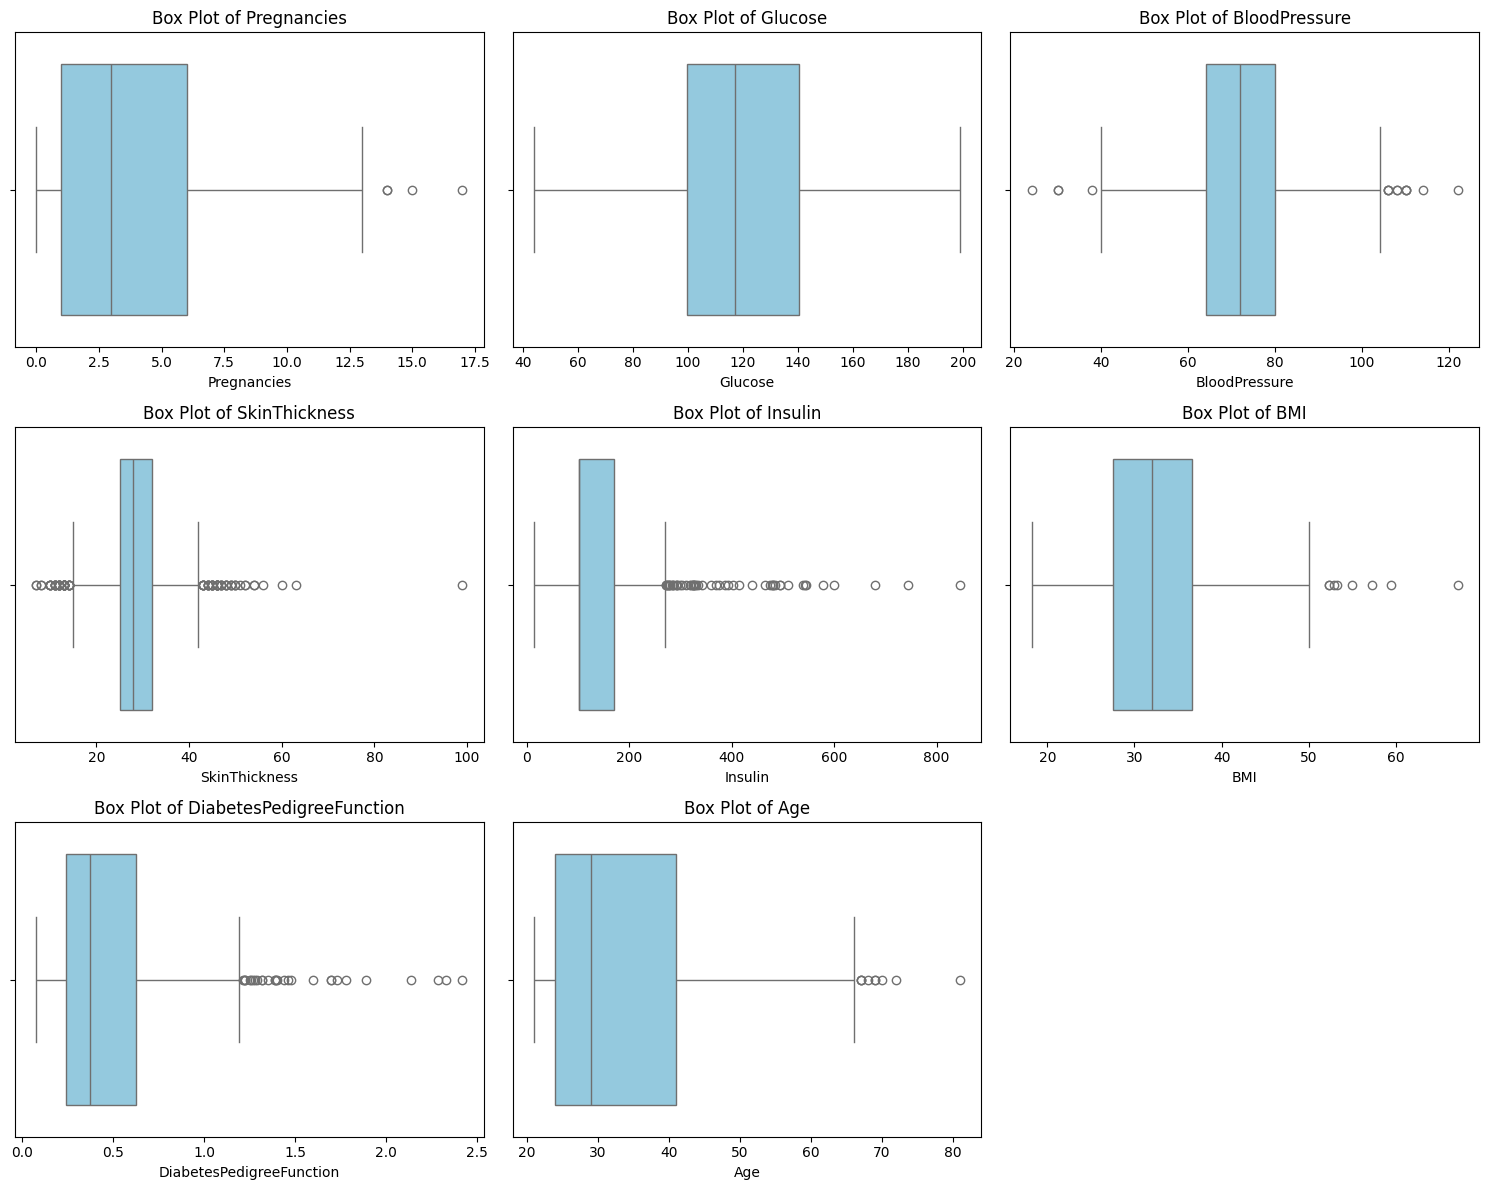

In [ ]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

In [ ]:
def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)  # First quartile (25%)
        Q3 = df_clean[col].quantile(0.75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]

    return df_clean

df_cleaned = remove_outliers(df, numerical_columns)

In [ ]:
df_cleaned.shape[0],df_cleaned.shape[1]

(579, 9)

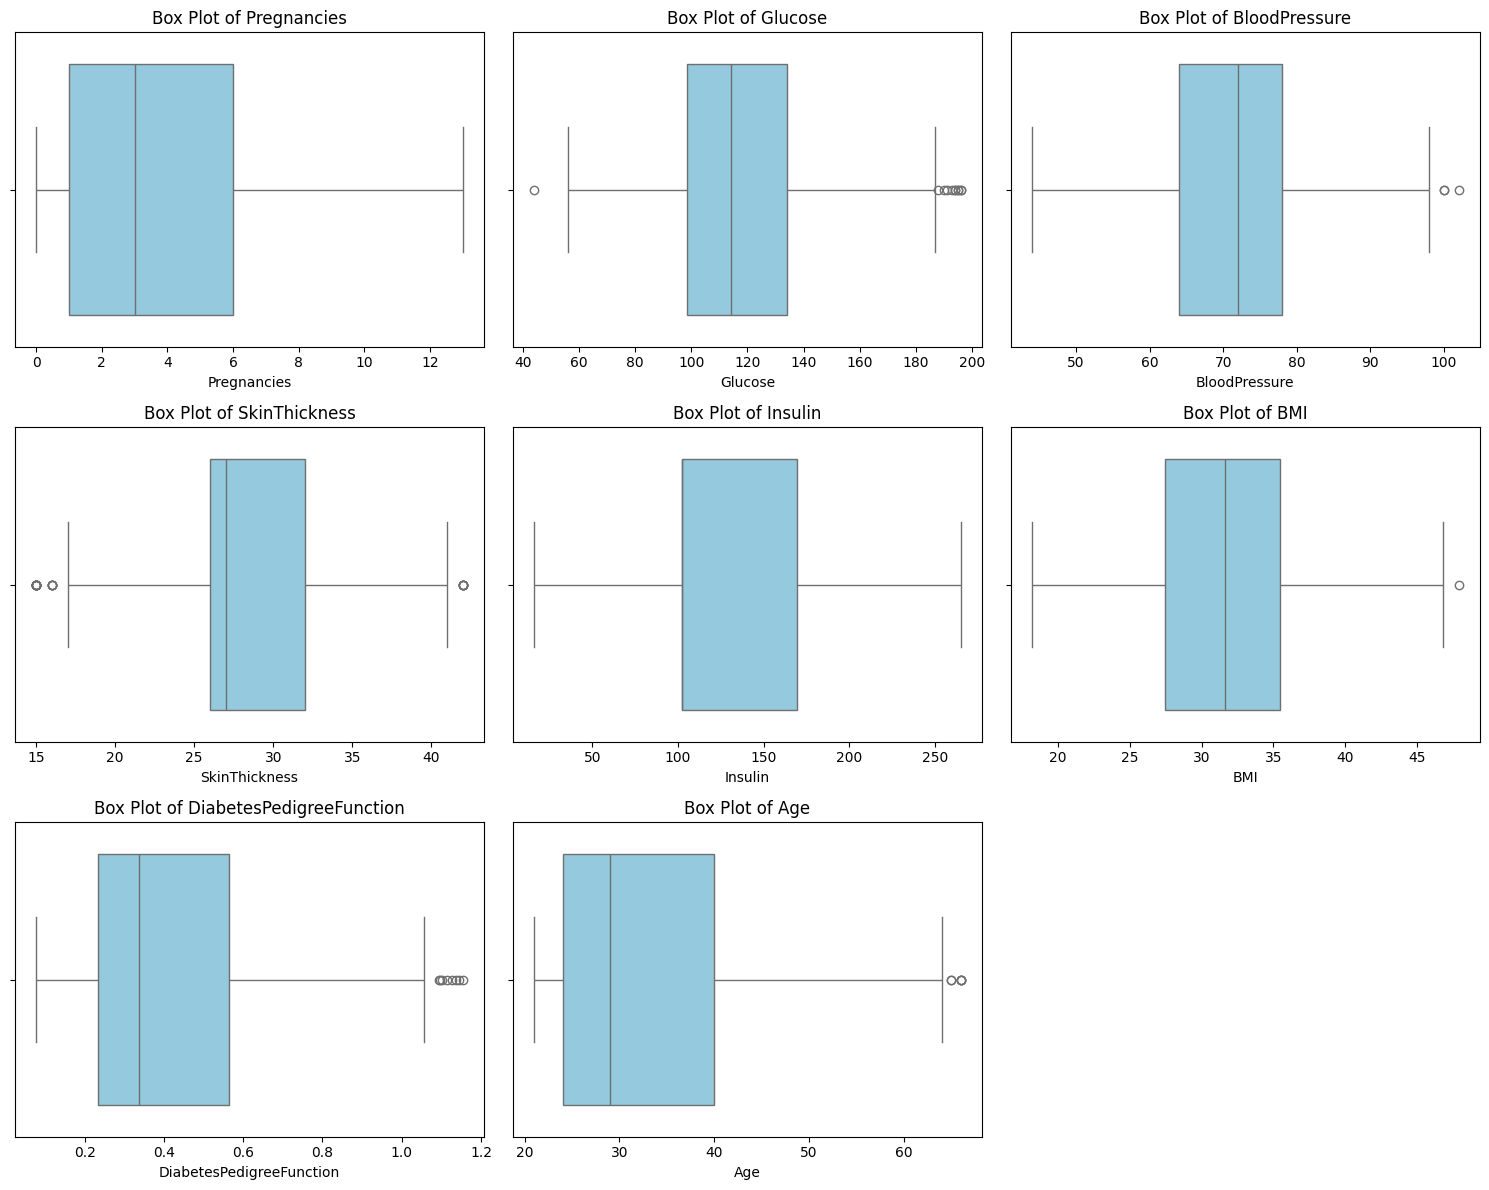

In [ ]:
#Show outlier after clean data
plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df_cleaned[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 579 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               579 non-null    int64  
 1   Glucose                   579 non-null    float64
 2   BloodPressure             579 non-null    float64
 3   SkinThickness             579 non-null    float64
 4   Insulin                   579 non-null    float64
 5   BMI                       579 non-null    float64
 6   DiabetesPedigreeFunction  579 non-null    float64
 7   Age                       579 non-null    int64  
 8   Outcome                   579 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 45.2 KB


In [ ]:
df_cleaned.reset_index(inplace = True , drop = True)
df_cleaned.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
287,0,105.0,68.0,22.0,102.5,20.0,0.236,22,0
428,6,99.0,60.0,19.0,54.0,26.9,0.497,32,0
89,5,124.0,74.0,32.0,169.5,34.0,0.220,38,1
520,4,118.0,70.0,27.0,102.5,44.5,0.904,26,0
497,10,162.0,84.0,27.0,102.5,27.7,0.182,54,0


# EDA

In [ ]:
pio.renderers.default = 'colab'
# สร้าง Pie Chart
fig = px.pie(values=df_cleaned['Outcome'].value_counts(),
             names=['No Diabetes', 'Diabetes'],
             title='Percentage of diabetics in the data'
             ).update_traces(textinfo='label+percent')

fig.show()


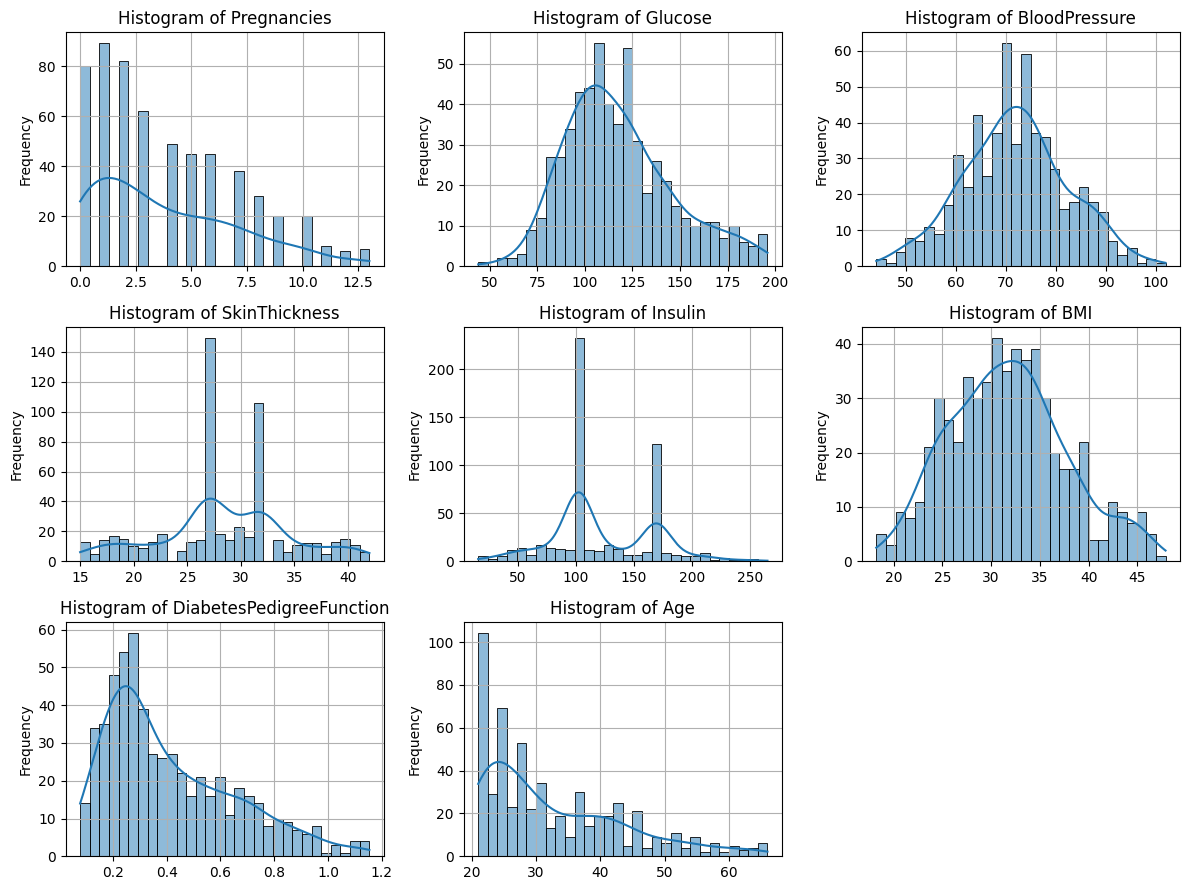

In [ ]:
import math
columns_histo = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# กำหนดให้มี 3 แถว และคำนวณจำนวนคอลัมน์อัตโนมัติ
rows = 3
cols = math.ceil(len(columns_histo) / rows)  # คำนวณจำนวนคอลัมน์ให้พอดี

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))  # ปรับขนาดกราฟให้เล็กลง
axes = axes.flatten()  # แปลงเป็น 1D array เพื่อให้เข้าถึง index ได้ง่าย

# วนลูปสร้าง Histogram แต่ละตัวแปร
for i, col in enumerate(columns_histo):
    sns.histplot(df_cleaned[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

# ลบช่องว่างที่ไม่มีข้อมูล (กรณีจำนวนกราฟไม่พอดีกับ grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

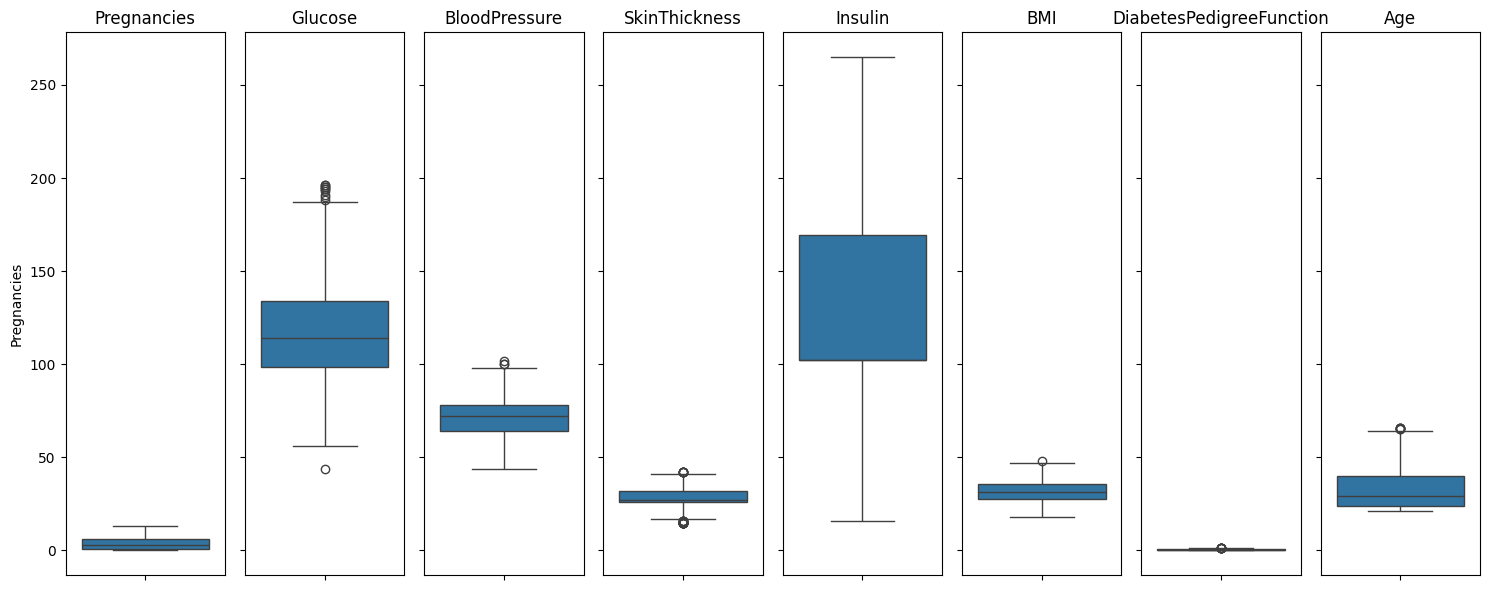

In [ ]:
columns_box = ['Pregnancies','Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                 'BMI', 'DiabetesPedigreeFunction', 'Age']

# กำหนดให้มี 1 แถว หลายคอลัมน์
fig, axes = plt.subplots(1, len(columns_box), figsize=(15, 6), sharey=True)

# วนลูปสร้าง Box Plot แต่ละตัวแปร
for i, col in enumerate(columns_box):
    sns.boxplot(y=df_cleaned[col], ax=axes[i])  # ตั้งค่าแกน Y เพื่อให้แนวตั้ง
    axes[i].set_title(f"{col}")  # ตั้งชื่อกราฟ
    axes[i].set_xlabel("")  # ไม่ต้องแสดงชื่อแกน X เพื่อความสวยงาม

# จัด Layout ให้สวยงาม
plt.tight_layout()
plt.show()

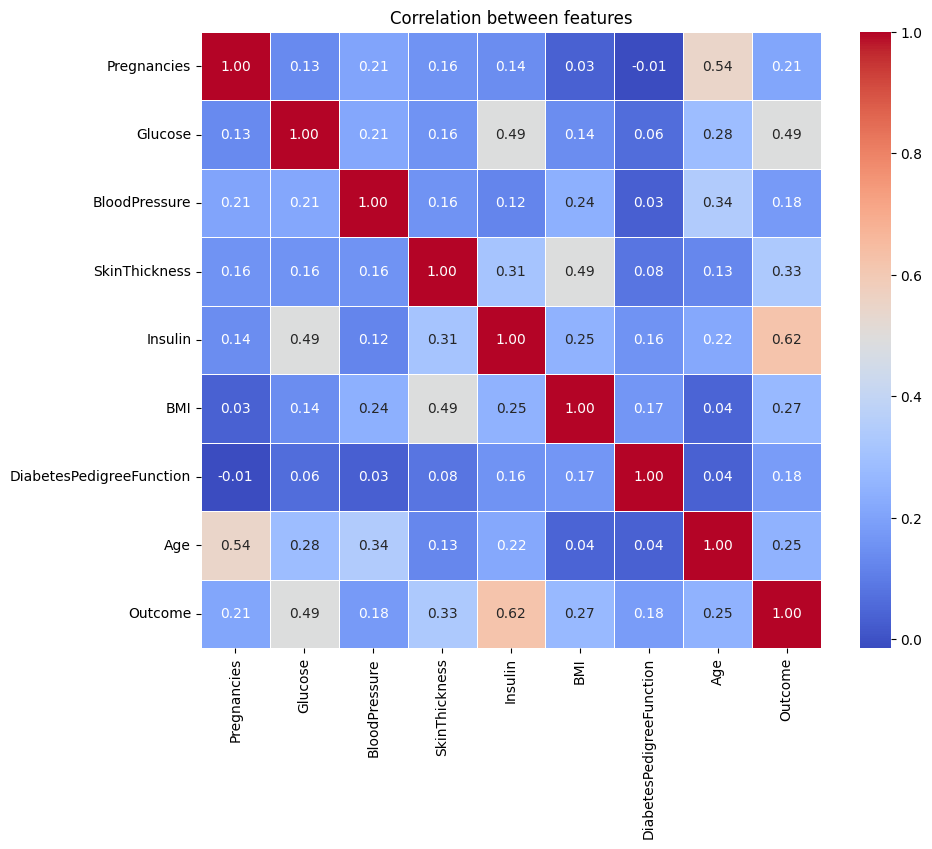

In [ ]:
plt.figure(figsize=(10, 8))  # กำหนดขนาดกราฟ
sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation between features")
plt.show()

Categorize Values and visualizing the categories

In [ ]:
def categorize_values(df):
    df['Glucose_Category'] = pd.cut(df['Glucose'], bins=[0, 99, 125, float('inf')],
                                    labels=['Normal', 'Prediabetes', 'Diabetes'], right=False)

    df['BloodPressure_Category'] = pd.cut(df['BloodPressure'], bins=[44, 89, 99, 104, float('inf')],
                                          labels=['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2'], right=False)

    df['SkinThickness_Category'] = pd.cut(df['SkinThickness'], bins=[0, 30, float('inf')],
                                          labels=['Normal', 'Elevated'], right=False)

    df['Insulin_Category'] = pd.cut(df['Insulin'], bins=[0, 24.9, float('inf')],
                                    labels=['Normal', 'High'], right=False)

    df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                                labels=['Underweight', 'Normal weight', 'Overweight', 'Obese (Class 1)', 'Obese (Class 2)', 'Obese (Class 3)'], right=False)

    df['DiabetesPedigreeFunction_Category'] = pd.cut(df['DiabetesPedigreeFunction'], bins=[0, 0.5, 1.0, 1.5, 2.5],
                                                    labels=['Low risk', 'Moderate risk', 'High risk', 'Very high risk'], right=False)

    return df
df_cleaned = categorize_values(df_cleaned)

In [ ]:
df_cleaned.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_Category,BloodPressure_Category,SkinThickness_Category,Insulin_Category,BMI_Category,DiabetesPedigreeFunction_Category
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Diabetes,Normal,Elevated,High,Obese (Class 1),Moderate risk
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Normal,Normal,Normal,High,Overweight,Low risk
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Diabetes,Normal,Elevated,High,Normal weight,Moderate risk
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Normal,Normal,Normal,High,Overweight,Low risk
4,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0,Prediabetes,Normal,Normal,High,Overweight,Low risk


In [ ]:
pio.renderers.default = 'colab'

columns_Category = ['BMI_Category','DiabetesPedigreeFunction_Category','Glucose_Category','BloodPressure_Category','SkinThickness_Category','Insulin_Category']

for col in columns_Category:
    fig = px.pie(title=f'{col}',
                 values=df_cleaned[col].value_counts().values,
                 names=df_cleaned[col].value_counts().index
                ).update_traces(textinfo='label+percent')

    fig.show()

# Data Pre-processing

In [ ]:
df_cleaned.drop(df_cleaned.columns.to_list()[9:] , axis = 1,inplace = True)

In [ ]:
X = df_cleaned.drop('Outcome',axis=1)
y = df_cleaned['Outcome']

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.25 , random_state = 44 , shuffle = True)

In [ ]:
print(f'Shape of X_Train {X_train.shape}')
print(f'Shape of X_Test {X_test.shape}')
print(f'Shape of Y_Train {y_train.shape}')
print(f'Shape of Y_Test {y_test.shape}')

Shape of X_Train (434, 8)
Shape of X_Test (145, 8)
Shape of Y_Train (434,)
Shape of Y_Test (145,)


# Modeling

In [ ]:
def kfolds(model, model_name):
    model = cross_val_score(model, X,y, cv=5)
    model_score = np.average(model)
    print(f"{model_name} score on cross validation: {model_score * 100}%")

def train(model, model_name):
    model.fit(X_train, y_train)
    model_train_score = model.score(X_train, y_train)
    model_test_score = model.score(X_test, y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")


def class_report(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

**Logistic Regression**

In [ ]:
lr = LogisticRegression()
kfolds(lr, "Logistic Regression")
train(lr, "Logistic Regression")

Logistic Regression score on cross validation: 86.70014992503748%
Logistic Regression model score on Training data: 85.02304147465438%
Logistic Regression model score on Testing data: 91.0344827586207%


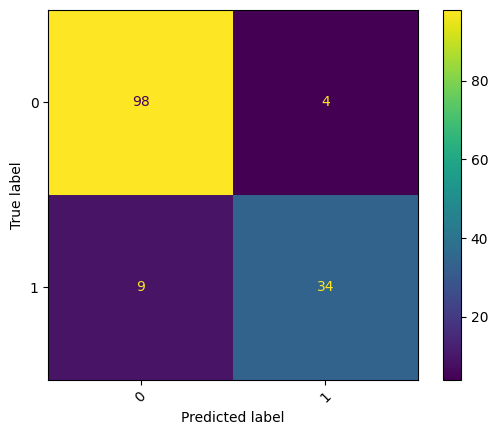

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [ ]:
class_report(lr)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       102
           1       0.89      0.79      0.84        43

    accuracy                           0.91       145
   macro avg       0.91      0.88      0.89       145
weighted avg       0.91      0.91      0.91       145



**Random Forest**

In [ ]:
rf = RandomForestClassifier()
kfolds(rf, "Random Forest")
train(rf, "Random Forest")

Random Forest score on cross validation: 89.81559220389805%
Random Forest model score on Training data: 100.0%
Random Forest model score on Testing data: 93.79310344827586%


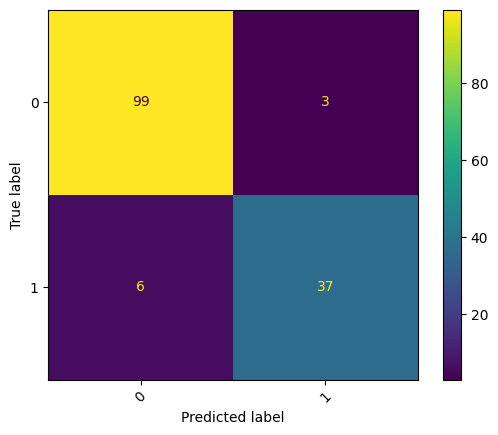

In [ ]:
ConfusionMatrixDisplay.from_estimator(rf,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [ ]:
class_report(rf)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       102
           1       0.93      0.86      0.89        43

    accuracy                           0.94       145
   macro avg       0.93      0.92      0.92       145
weighted avg       0.94      0.94      0.94       145



**KNN**

In [ ]:
knn = KNeighborsClassifier()
kfolds(knn, "KNN")
train(knn, "KNN")

KNN score on cross validation: 89.11244377811094%
KNN model score on Training data: 90.09216589861751%
KNN model score on Testing data: 92.41379310344827%


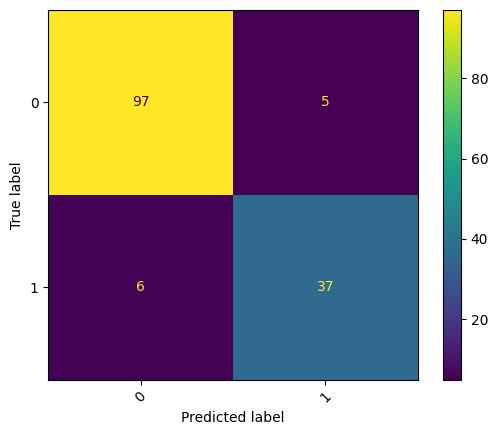

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [ ]:
class_report(knn)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       102
           1       0.88      0.86      0.87        43

    accuracy                           0.92       145
   macro avg       0.91      0.91      0.91       145
weighted avg       0.92      0.92      0.92       145



**AdaBoost**

In [ ]:
ada = AdaBoostClassifier()
kfolds(ada, "AdaBoost")
train(ada, "AdaBoost")

AdaBoost score on cross validation: 89.6431784107946%
AdaBoost model score on Training data: 93.54838709677419%
AdaBoost model score on Testing data: 92.41379310344827%


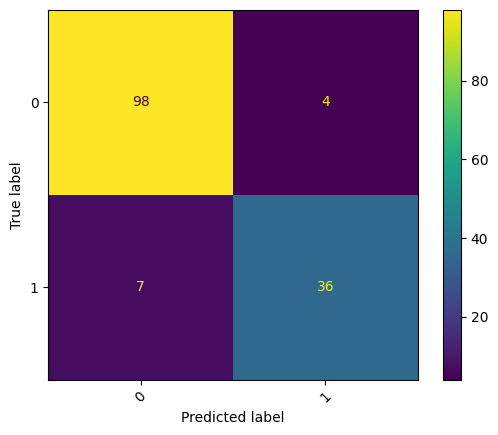

In [ ]:
ConfusionMatrixDisplay.from_estimator(ada,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [ ]:
class_report(ada)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       102
           1       0.90      0.84      0.87        43

    accuracy                           0.92       145
   macro avg       0.92      0.90      0.91       145
weighted avg       0.92      0.92      0.92       145



**GradientBoosting**

In [ ]:
gb = GradientBoostingClassifier(n_estimators=150, random_state=20)
kfolds(gb, "Boosting")
train(gb, "Boosting")

Boosting score on cross validation: 89.2968515742129%
Boosting model score on Training data: 100.0%
Boosting model score on Testing data: 91.72413793103448%


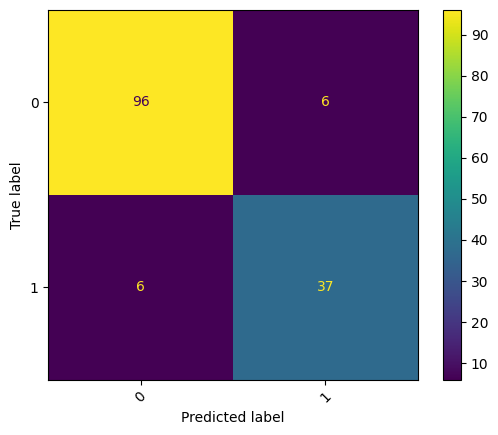

In [ ]:
ConfusionMatrixDisplay.from_estimator(gb,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [ ]:
class_report(gb)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       102
           1       0.86      0.86      0.86        43

    accuracy                           0.92       145
   macro avg       0.90      0.90      0.90       145
weighted avg       0.92      0.92      0.92       145



**DecisionTree**

In [ ]:
dt = DecisionTreeClassifier()
kfolds(dt, "Decision Tree")
train(dt, "Decision Tree")

Decision Tree score on cross validation: 87.39880059970014%
Decision Tree model score on Training data: 100.0%
Decision Tree model score on Testing data: 90.3448275862069%


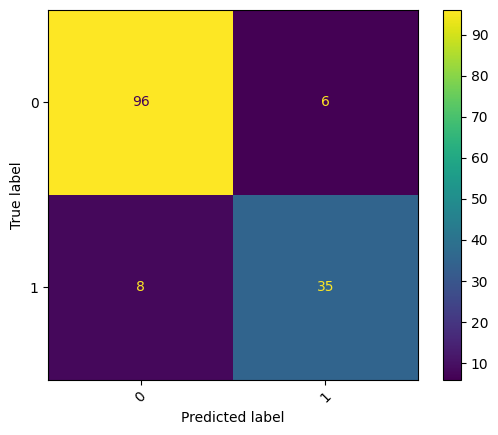

In [ ]:
ConfusionMatrixDisplay.from_estimator(dt,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [ ]:
class_report(dt)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       102
           1       0.85      0.81      0.83        43

    accuracy                           0.90       145
   macro avg       0.89      0.88      0.88       145
weighted avg       0.90      0.90      0.90       145



**SVM**

In [ ]:
svm_model = SVC(C=50 , kernel='rbf')
kfolds(svm_model, "SVM")
train(svm_model, "SVM")

SVM score on cross validation: 88.42428785607197%
SVM model score on Training data: 90.09216589861751%
SVM model score on Testing data: 92.41379310344827%


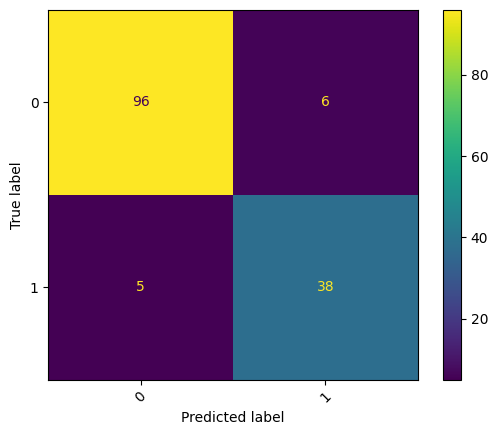

In [ ]:
ConfusionMatrixDisplay.from_estimator(svm_model,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [ ]:
class_report(svm_model)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       102
           1       0.86      0.88      0.87        43

    accuracy                           0.92       145
   macro avg       0.91      0.91      0.91       145
weighted avg       0.92      0.92      0.92       145



**Xgboost**

In [ ]:
xgboost = XGBClassifier()
kfolds(xgboost, "Xgboost")
train(xgboost, "Xgboost")

Xgboost score on cross validation: 89.9865067466267%
Xgboost model score on Training data: 100.0%
Xgboost model score on Testing data: 92.41379310344827%


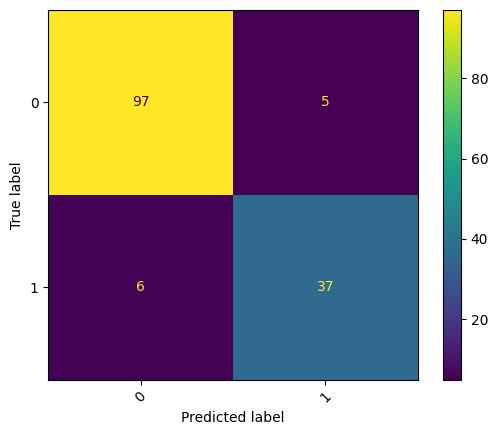

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgboost,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [ ]:
class_report(xgboost)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       102
           1       0.88      0.86      0.87        43

    accuracy                           0.92       145
   macro avg       0.91      0.91      0.91       145
weighted avg       0.92      0.92      0.92       145



**Bagging**

In [ ]:
bagg_model = BaggingClassifier()
kfolds(bagg_model, "Bagging")
train(bagg_model, "Bagging")

Bagging score on cross validation: 89.4632683658171%
Bagging model score on Training data: 98.38709677419355%
Bagging model score on Testing data: 90.3448275862069%


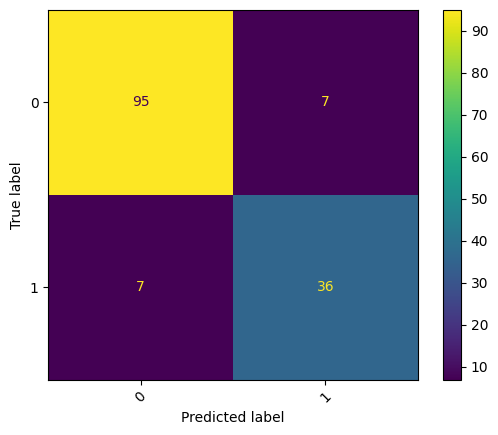

In [ ]:
ConfusionMatrixDisplay.from_estimator(bagg_model,
                                       X_test,
                                       y_test,
                                       xticks_rotation=45
    );

In [ ]:
class_report(bagg_model)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       102
           1       0.84      0.84      0.84        43

    accuracy                           0.90       145
   macro avg       0.88      0.88      0.88       145
weighted avg       0.90      0.90      0.90       145



# Test Model

In [ ]:
# ทดสอบการทำนาย
sample_input = [[5, 120, 70, 25, 100, 24.5, 0.5, 30]]  # ข้อมูลตัวอย่าง
prediction = rf.predict(sample_input)

print("ผลการทำนาย:", "มีความเสี่ยงเป็นเบาหวาน" if prediction[0] == 1 else "ไม่มีความเสี่ยง")


ผลการทำนาย: ไม่มีความเสี่ยง


# Save Model

In [ ]:
import joblib
joblib.dump(rf, "diabetes_random_forest.pkl")
print("✅ โมเดลถูกบันทึกเป็นไฟล์ diabetes_random_forest.pkl แล้ว")

✅ โมเดลถูกบันทึกเป็นไฟล์ diabetes_random_forest.pkl แล้ว
